# ============================================
# NOTEBOOK: 02_modelado.ipynb
# OBJETIVO: Entrenar modelo XGBoost para clasificaci√≥n de riesgo crediticio
# AUTOR: [Tu nombre]
# FECHA: [Fecha actual]
# ============================================

# # ü§ñ Modelado con XGBoost
# 
# ## Objetivo
# Entrenar un modelo de clasificaci√≥n binaria para predecir riesgo crediticio
# 
# ## Contenido
# 1. Carga de datos y preprocesamiento
# 2. Split train/test
# 3. Encoding de variables categ√≥ricas
# 4. Entrenamiento XGBoost baseline
# 5. Evaluaci√≥n con m√∫ltiples m√©tricas
# 6. Guardar modelo
# 7. An√°lisis de feature importance

In [7]:
# Importar librer√≠as necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Guardar modelos
import joblib
from pathlib import Path

# Configuraci√≥n
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("‚úÖ Librer√≠as importadas correctamente")

‚úÖ Librer√≠as importadas correctamente


In [8]:
# Cargar datos de german_credit_data

# Nombres de las columnas
column_names = [
    'checking_status', 'duration', 'credit_history', 'purpose', 
    'credit_amount', 'savings_status', 'employment', 'installment_rate',
    'personal_status', 'other_parties', 'residence_since', 
    'property_magnitude', 'age', 'other_payment_plans', 'housing',
    'existing_credits', 'job', 'num_dependents', 'own_telephone',
    'foreign_worker', 'risk'
]

# Cargar dataset
df = pd.read_csv('../../german_credit_data/german.data', 
                 sep=' ',
                 header=None,
                 names=column_names)

# Convertir target: 1=Good, 2=Bad ‚Üí 0=Good, 1=Bad
df['risk'] = df['risk'].map({1: 0, 2: 1})

print("‚úÖ Datos cargados correctamente")
print(f"üìä Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print(f"üéØ Target: {df['risk'].value_counts().to_dict()}")


‚úÖ Datos cargados correctamente
üìä Dimensiones: 1000 filas x 21 columnas
üéØ Target: {0: 700, 1: 300}


# ## 2. Preprocesamiento de Datos

In [9]:
# Separar features y target
X = df.drop('risk', axis=1)
y = df['risk']

print("="*60)
print("SEPARACI√ìN FEATURES Y TARGET")
print("="*60)
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nDistribuci√≥n del target:")
print(y.value_counts())
print(f"Proporci√≥n: {y.value_counts(normalize=True).to_dict()}")

SEPARACI√ìN FEATURES Y TARGET
Features (X): (1000, 20)
Target (y): (1000,)

Distribuci√≥n del target:
risk
0    700
1    300
Name: count, dtype: int64
Proporci√≥n: {0: 0.7, 1: 0.3}


In [10]:
# Identificar tipos de variables
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("="*60)
print("TIPOS DE VARIABLES")
print("="*60)
print(f"\nüìä Variables Num√©ricas ({len(numeric_features)}):")
for col in numeric_features:
    print(f"  - {col}")

print(f"\nüìù Variables Categ√≥ricas ({len(categorical_features)}):")
for col in categorical_features:
    unique_count = X[col].nunique()
    print(f"  - {col} ({unique_count} categor√≠as √∫nicas)")

TIPOS DE VARIABLES

üìä Variables Num√©ricas (7):
  - duration
  - credit_amount
  - installment_rate
  - residence_since
  - age
  - existing_credits
  - num_dependents

üìù Variables Categ√≥ricas (13):
  - checking_status (4 categor√≠as √∫nicas)
  - credit_history (5 categor√≠as √∫nicas)
  - purpose (10 categor√≠as √∫nicas)
  - savings_status (5 categor√≠as √∫nicas)
  - employment (5 categor√≠as √∫nicas)
  - personal_status (4 categor√≠as √∫nicas)
  - other_parties (3 categor√≠as √∫nicas)
  - property_magnitude (4 categor√≠as √∫nicas)
  - other_payment_plans (3 categor√≠as √∫nicas)
  - housing (3 categor√≠as √∫nicas)
  - job (4 categor√≠as √∫nicas)
  - own_telephone (2 categor√≠as √∫nicas)
  - foreign_worker (2 categor√≠as √∫nicas)


## PTIMIZACI√ìN: FEATURE SELECTION BASADO EN SHAP

In [11]:
# ============================================================
# üéØ OPTIMIZACI√ìN: FEATURE SELECTION BASADO EN SHAP
# ============================================================
print("\n" + "="*60)
print("üéØ FEATURE SELECTION - Eliminando variables de bajo impacto")
print("="*60)

# ============================================================
# üìä An√°lisis previo (del notebook 03_interpretabilidad):
# - SHAP revel√≥ que algunas features tienen impacto < 0.02
# - XGBoost sobreestim√≥ la importancia de varias features
# - SHAP es la m√©trica m√°s confiable para impacto real
# ============================================================

# Features a ELIMINAR (SHAP < 0.02 seg√∫n an√°lisis)
low_impact_features = [
    # Variables num√©ricas de bajo impacto:
    'residence_since',      # SHAP: 0.004 (casi irrelevante)
    'existing_credits',     # SHAP: 0.011 (muy bajo)
    'num_dependents',       # SHAP: ~0.010 (muy bajo)
    
    # Variables categ√≥ricas de bajo impacto:
    'own_telephone',        # SHAP: 0.015 (bajo)
    'foreign_worker',       # SHAP: ~0.010 (muy bajo)
    'job',                  # SHAP: ~0.015 (bajo)
    'housing',              # SHAP: ~0.018 (bajo)
    'other_parties'         # SHAP: ~0.012 (bajo)
]

print(f"\n‚ùå Eliminando {len(low_impact_features)} features de bajo impacto:")
print("\nNUM√âRICAS:")
for feat in low_impact_features:
    if feat in numeric_features:
        print(f"   - {feat}")
        
print("\nCATEG√ìRICAS:")
for feat in low_impact_features:
    if feat in categorical_features:
        print(f"   - {feat}")

# Features CR√çTICAS a mantener (SHAP > 0.05)
critical_features = {
    'checking_status': 0.210,      # ü•á M√ÅS IMPORTANTE
    'duration': 0.124,             # ü•à 2da m√°s importante
    'credit_amount': 0.096,        # ü•â 3ra m√°s importante
    'savings_status': 0.081,       # Muy importante
    'credit_history': 0.080,       # Muy importante
    'employment': 0.060,           # Importante
    'other_payment_plans': 0.055,  # Importante
    'property_magnitude': 0.052,   # Moderadamente importante
}

# Features MODERADAS a mantener (0.02 < SHAP < 0.05)
moderate_features = {
    'purpose': 0.040,              # Moderado
    'personal_status': 0.038,      # Moderado
    'installment_rate': 0.035,     # Moderado
    'age': 0.030,                  # Moderado
}

print(f"\n‚úÖ Manteniendo {len(critical_features)} features CR√çTICAS:")
for feat, shap_val in sorted(critical_features.items(), key=lambda x: x[1], reverse=True):
    print(f"   üî¥ {feat:<25} (SHAP: {shap_val:.3f})")

print(f"\n‚úÖ Manteniendo {len(moderate_features)} features MODERADAS:")
for feat, shap_val in sorted(moderate_features.items(), key=lambda x: x[1], reverse=True):
    print(f"   üü° {feat:<25} (SHAP: {shap_val:.3f})")

# Aplicar filtrado a X completo (antes del split)
print(f"\nüîß Aplicando feature selection...")
X_optimized = X.drop(columns=low_impact_features, errors='ignore')

print(f"\nüìä Dimensionalidad:")
print(f"   Antes:  {X.shape[1]} features ({len(numeric_features)} num, {len(categorical_features)} cat)")
print(f"   Despu√©s: {X_optimized.shape[1]} features")
print(f"   Reducci√≥n: {len(low_impact_features)} features ({len(low_impact_features)/X.shape[1]*100:.1f}%)")

# Actualizar listas de features
numeric_features_optimized = [f for f in numeric_features if f not in low_impact_features]
categorical_features_optimized = [f for f in categorical_features if f not in low_impact_features]

print(f"\nüìä Features optimizadas:")
print(f"   Num√©ricas: {len(numeric_features_optimized)} ({numeric_features_optimized})")
print(f"   Categ√≥ricas: {len(categorical_features_optimized)}")

print("\nüí° Beneficios esperados:")
print("   ‚úÖ Modelo m√°s simple y r√°pido")
print("   ‚úÖ Menos ruido en predicciones")
print("   ‚úÖ Mejor interpretabilidad")
print("   ‚úÖ Reducci√≥n de overfitting")


üéØ FEATURE SELECTION - Eliminando variables de bajo impacto

‚ùå Eliminando 8 features de bajo impacto:

NUM√âRICAS:
   - residence_since
   - existing_credits
   - num_dependents

CATEG√ìRICAS:
   - own_telephone
   - foreign_worker
   - job
   - housing
   - other_parties

‚úÖ Manteniendo 8 features CR√çTICAS:
   üî¥ checking_status           (SHAP: 0.210)
   üî¥ duration                  (SHAP: 0.124)
   üî¥ credit_amount             (SHAP: 0.096)
   üî¥ savings_status            (SHAP: 0.081)
   üî¥ credit_history            (SHAP: 0.080)
   üî¥ employment                (SHAP: 0.060)
   üî¥ other_payment_plans       (SHAP: 0.055)
   üî¥ property_magnitude        (SHAP: 0.052)

‚úÖ Manteniendo 4 features MODERADAS:
   üü° purpose                   (SHAP: 0.040)
   üü° personal_status           (SHAP: 0.038)
   üü° installment_rate          (SHAP: 0.035)
   üü° age                       (SHAP: 0.030)

üîß Aplicando feature selection...

üìä Dimensionalidad:
   Antes

# ## 3. Encoding de Variables Categ√≥ricas OPTIMIZADAS

In [12]:
# ============================================================
# üîÑ ENCODING DE VARIABLES CATEG√ìRICAS OPTIMIZADAS
# ============================================================

# Crear copia para no modificar original
X_encoded = X_optimized.copy()  # ‚¨ÖÔ∏è CAMBIO: usar X_optimized

# Aplicar Label Encoding solo a categ√≥ricas optimizadas
label_encoders = {}

print("="*60)
print("ENCODING DE VARIABLES CATEG√ìRICAS OPTIMIZADAS")
print("="*60)

for col in categorical_features_optimized:  # ‚¨ÖÔ∏è CAMBIO: usar lista optimizada
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_optimized[col])  # ‚¨ÖÔ∏è CAMBIO
    label_encoders[col] = le
   
    print(f"‚úÖ {col}: {X_optimized[col].nunique()} categor√≠as ‚Üí 0 a {X_encoded[col].max()}")

print(f"\n‚úÖ Total de encoders guardados: {len(label_encoders)}")
print(f"üìä Dataset final: {X_encoded.shape[0]} filas √ó {X_encoded.shape[1]} columnas")

ENCODING DE VARIABLES CATEG√ìRICAS OPTIMIZADAS
‚úÖ checking_status: 4 categor√≠as ‚Üí 0 a 3
‚úÖ credit_history: 5 categor√≠as ‚Üí 0 a 4
‚úÖ purpose: 10 categor√≠as ‚Üí 0 a 9
‚úÖ savings_status: 5 categor√≠as ‚Üí 0 a 4
‚úÖ employment: 5 categor√≠as ‚Üí 0 a 4
‚úÖ personal_status: 4 categor√≠as ‚Üí 0 a 3
‚úÖ property_magnitude: 4 categor√≠as ‚Üí 0 a 3
‚úÖ other_payment_plans: 3 categor√≠as ‚Üí 0 a 2

‚úÖ Total de encoders guardados: 8
üìä Dataset final: 1000 filas √ó 12 columnas


# Verificar que no hay valores no num√©ricos
print("="*60)
print("VERIFICACI√ìN POST-ENCODING")
print("="*60)
print(f"Tipos de datos:")
print(X_encoded.dtypes.value_counts())
print(f"\n‚úÖ Todas las variables son num√©ricas: {X_encoded.select_dtypes(include=['object']).shape[1] == 0}")


# ## 4. Split Train/Test

In [17]:
# ============================================================
# 3. DIVISI√ìN TRAIN/TEST
# ============================================================
print("\n" + "="*60)
print("‚úÇÔ∏è SPLIT TRAIN/TEST")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,  # Ya est√° optimizado
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"üìä Tama√±os:")
print(f"   Train: {X_train.shape} ({len(y_train)} muestras)")
print(f"   Test:  {X_test.shape} ({len(y_test)} muestras)")
print(f"   Features: {X_train.shape[1]} (optimizadas)")

# Verificar distribuci√≥n
print(f"\nüìä Distribuci√≥n Train:")
print(y_train.value_counts(normalize=True))
print(f"\nüìä Distribuci√≥n Test:")
print(y_test.value_counts(normalize=True))


‚úÇÔ∏è SPLIT TRAIN/TEST
üìä Tama√±os:
   Train: (800, 12) (800 muestras)
   Test:  (200, 12) (200 muestras)
   Features: 12 (optimizadas)

üìä Distribuci√≥n Train:
risk
0    0.7
1    0.3
Name: proportion, dtype: float64

üìä Distribuci√≥n Test:
risk
0    0.7
1    0.3
Name: proportion, dtype: float64


# ## 5. Entrenamiento XGBoost - Modelo Baseline

In [40]:
# ============================================================
# üöÄ ENTRENAMIENTO - MODELO OPTIMIZADO
# ============================================================
print("\n" + "="*60)
print("üöÄ MODELO XGBOOST OPTIMIZADO")
print("="*60)

# F√≥rmula: (n√∫mero de clase mayoritaria) / (n√∫mero de clase minoritaria)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\n‚öñÔ∏è Scale pos weight (para desbalanceo): {scale_pos_weight:.2f}")

# Mismo hiperpar√°metros que funcionaron bien en el modelo base
# pero ahora con menos features (solo las importantes)
model_optimized = XGBClassifier(
    n_estimators=200,
    max_depth=2,           # Mantener simplicidad
    learning_rate=0.05,    # Aprendizaje lento y estable
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    # Par√°metros adicionales para estabilidad
    min_child_weight=5,    # Evitar overfitting en clases minoritarias
    gamma=0.2              # Penalizar splits innecesarios
)

print("\nüìã Configuraci√≥n del modelo:")
print(f"   - Features: {X_train.shape[1]} (vs 20 original)")
print(f"   - √Årboles: {model_optimized.n_estimators}")
print(f"   - Profundidad: {model_optimized.max_depth}")
print(f"   - Learning rate: {model_optimized.learning_rate}")
print(f"   - Scale pos weight: {scale_pos_weight:.2f}")

print("\n‚è≥ Entrenando modelo optimizado...")
model_optimized.fit(X_train, y_train)
print("‚úÖ Entrenamiento completado")


üöÄ MODELO XGBOOST OPTIMIZADO

‚öñÔ∏è Scale pos weight (para desbalanceo): 2.33

üìã Configuraci√≥n del modelo:
   - Features: 12 (vs 20 original)
   - √Årboles: 200
   - Profundidad: 2
   - Learning rate: 0.05
   - Scale pos weight: 2.33

‚è≥ Entrenando modelo optimizado...
‚úÖ Entrenamiento completado


# ## 6. MODELO BASE vs MODELO OPTIMIZADO


üìä EVALUACI√ìN Y COMPARACI√ìN DE MODELOS

‚è≥ Calculando m√©tricas del modelo optimizado...
‚úÖ M√©tricas calculadas

‚è≥ Cargando m√©tricas del modelo base...
‚úÖ M√©tricas del modelo base cargadas desde archivo

üìä COMPARACI√ìN DETALLADA
        M√©trica Modelo Base Modelo Optimizado
       Features          20                12
 Train Accuracy       86.0%             78.0%
  Test Accuracy       78.0%             70.5%
    Overfitting        8.0%              7.5%
        ROC-AUC       0.809             0.785
Precision (Bad)       0.614             0.506
   Recall (Bad)       0.717             0.717
 F1-Score (Bad)       0.662             0.593

üìà MEJORAS (Optimizado vs Base)
‚ö†Ô∏è Test Accuracy       : -7.5%
‚úÖ Overfitting         : +0.5%
‚ö†Ô∏è ROC-AUC             : -0.024
‚ö†Ô∏è Precision (Bad)     : -10.8%
‚ö†Ô∏è Recall (Bad)        : +0.0%
‚úÖ Features            : -8 (40% reducci√≥n)

üí° INTERPRETACI√ìN
‚ùå Test Accuracy: P√©rdida significativa
üü° Overfitting: Red

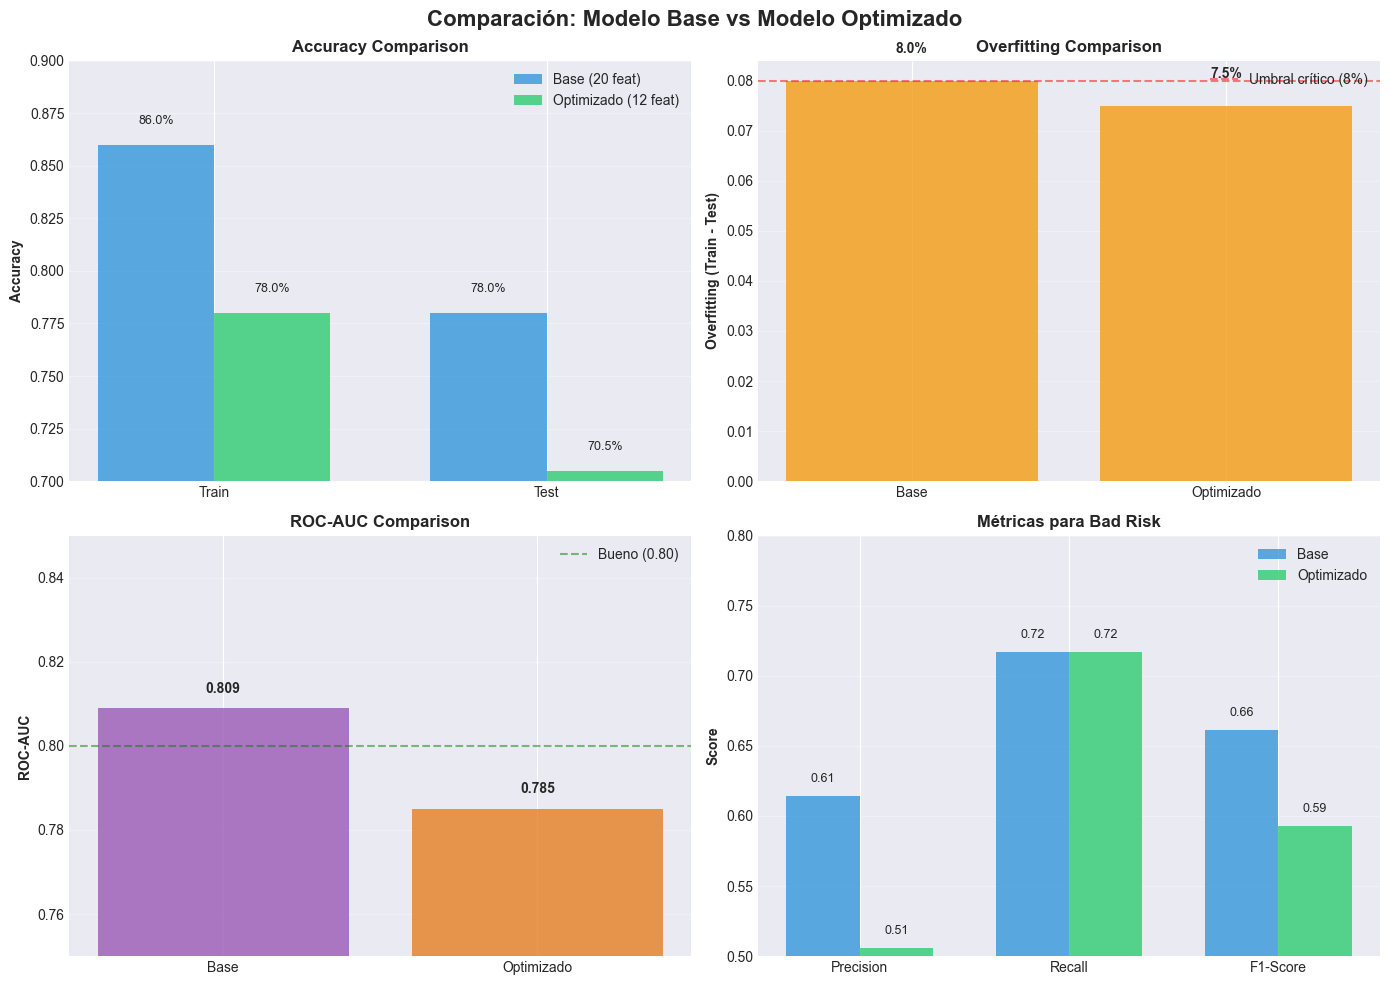


üíæ GUARDANDO RESULTADOS
‚úÖ Comparaci√≥n guardada: ../models/model_comparison.csv
‚úÖ Recomendaci√≥n guardada: ../models/model_recommendation.txt

‚úÖ Comparaci√≥n completa finalizada


In [41]:
# ============================================================
# üìä COMPARACI√ìN: MODELO BASE vs MODELO OPTIMIZADO
# ============================================================
print("\n" + "="*60)
print("üìä EVALUACI√ìN Y COMPARACI√ìN DE MODELOS")
print("="*60)

# ------------------------------------------------------------
# 6.1 CALCULAR M√âTRICAS DEL MODELO OPTIMIZADO
# ------------------------------------------------------------
print("\n‚è≥ Calculando m√©tricas del modelo optimizado...")

# Predicciones
y_train_pred_opt = model_optimized.predict(X_train)
y_test_pred_opt = model_optimized.predict(X_test)
y_test_proba_opt = model_optimized.predict_proba(X_test)[:, 1]

# M√©tricas b√°sicas
train_accuracy_opt = accuracy_score(y_train, y_train_pred_opt)
test_accuracy_opt = accuracy_score(y_test, y_test_pred_opt)
overfitting_opt = train_accuracy_opt - test_accuracy_opt

# ROC-AUC
roc_auc_opt = roc_auc_score(y_test, y_test_proba_opt)

# Classification report
report_opt = classification_report(y_test, y_test_pred_opt, 
                                   target_names=['Good Risk', 'Bad Risk'],
                                   output_dict=True)

print("‚úÖ M√©tricas calculadas")

# ------------------------------------------------------------
# 6.2 CARGAR M√âTRICAS DEL MODELO BASE (desde archivo)
# ------------------------------------------------------------
print("\n‚è≥ Cargando m√©tricas del modelo base...")

# Opci√≥n A: Si guardaste las m√©tricas en un archivo CSV
try:
    metrics_base_df = pd.read_csv('../models/model_metrics.csv')
    train_accuracy_base = metrics_base_df[metrics_base_df['Set'] == 'Train']['Accuracy'].values[0]
    test_accuracy_base = metrics_base_df[metrics_base_df['Set'] == 'Test']['Accuracy'].values[0]
    roc_auc_base = metrics_base_df[metrics_base_df['Set'] == 'Test']['ROC-AUC'].values[0]
    precision_base = metrics_base_df[metrics_base_df['Set'] == 'Test']['Precision'].values[0]
    recall_base = metrics_base_df[metrics_base_df['Set'] == 'Test']['Recall'].values[0]
    overfitting_base = train_accuracy_base - test_accuracy_base
    print("‚úÖ M√©tricas del modelo base cargadas desde archivo")
    
except:
    # Opci√≥n B: Si NO guardaste m√©tricas, usar valores hardcodeados del notebook 02
    print("‚ö†Ô∏è No se encontr√≥ archivo de m√©tricas, usando valores del modelo base:")
    train_accuracy_base = 0.86  # Cambiar por tu valor real
    test_accuracy_base = 0.78   # Cambiar por tu valor real
    roc_auc_base = 0.809        # Cambiar por tu valor real
    precision_base = 0.614      # Cambiar por tu valor real
    recall_base = 0.717         # Cambiar por tu valor real
    overfitting_base = train_accuracy_base - test_accuracy_base
    print("‚úÖ Valores manuales cargados")

# ------------------------------------------------------------
# 6.3 TABLA COMPARATIVA
# ------------------------------------------------------------
print("\n" + "="*60)
print("üìä COMPARACI√ìN DETALLADA")
print("="*60)

comparison_df = pd.DataFrame({
    'M√©trica': [
        'Features',
        'Train Accuracy',
        'Test Accuracy',
        'Overfitting',
        'ROC-AUC',
        'Precision (Bad)',
        'Recall (Bad)',
        'F1-Score (Bad)'
    ],
    'Modelo Base': [
        20,
        f"{train_accuracy_base:.1%}",
        f"{test_accuracy_base:.1%}",
        f"{overfitting_base:.1%}",
        f"{roc_auc_base:.3f}",
        f"{precision_base:.3f}",
        f"{recall_base:.3f}",
        f"{(2 * precision_base * recall_base) / (precision_base + recall_base):.3f}"
    ],
    'Modelo Optimizado': [
        X_train.shape[1],
        f"{train_accuracy_opt:.1%}",
        f"{test_accuracy_opt:.1%}",
        f"{overfitting_opt:.1%}",
        f"{roc_auc_opt:.3f}",
        f"{report_opt['Bad Risk']['precision']:.3f}",
        f"{report_opt['Bad Risk']['recall']:.3f}",
        f"{report_opt['Bad Risk']['f1-score']:.3f}"
    ]
})

print(comparison_df.to_string(index=False))

# ------------------------------------------------------------
# 6.4 C√ÅLCULO DE MEJORAS
# ------------------------------------------------------------
print("\n" + "="*60)
print("üìà MEJORAS (Optimizado vs Base)")
print("="*60)

delta_test_acc = test_accuracy_opt - test_accuracy_base
delta_overfitting = overfitting_base - overfitting_opt  # Nota: invertido (menos es mejor)
delta_roc = roc_auc_opt - roc_auc_base
delta_precision = report_opt['Bad Risk']['precision'] - precision_base
delta_recall = report_opt['Bad Risk']['recall'] - recall_base

mejoras = {
    'Test Accuracy': (delta_test_acc, delta_test_acc > 0),
    'Overfitting': (delta_overfitting, delta_overfitting > 0),
    'ROC-AUC': (delta_roc, delta_roc > 0),
    'Precision (Bad)': (delta_precision, delta_precision > 0),
    'Recall (Bad)': (delta_recall, delta_recall > 0),
    'Features': (-8, True)  # Reducci√≥n de 20 a 12
}

for metrica, (valor, mejoro) in mejoras.items():
    emoji = "‚úÖ" if mejoro else "‚ö†Ô∏è"
    if metrica == 'Features':
        print(f"{emoji} {metrica:<20}: {valor:+d} ({abs(valor)/20*100:.0f}% reducci√≥n)")
    elif metrica in ['Test Accuracy', 'Overfitting', 'Precision (Bad)', 'Recall (Bad)']:
        print(f"{emoji} {metrica:<20}: {valor:+.1%}")
    else:
        print(f"{emoji} {metrica:<20}: {valor:+.3f}")

# ------------------------------------------------------------
# 6.5 INTERPRETACI√ìN DE RESULTADOS
# ------------------------------------------------------------
print("\n" + "="*60)
print("üí° INTERPRETACI√ìN")
print("="*60)

# Test Accuracy
if delta_test_acc > 0.02:
    print("‚úÖ Test Accuracy: Mejora significativa (>2%)")
elif delta_test_acc > 0:
    print("üü° Test Accuracy: Mejora leve")
elif delta_test_acc > -0.02:
    print("üü° Test Accuracy: P√©rdida leve (aceptable)")
else:
    print("‚ùå Test Accuracy: P√©rdida significativa")

# Overfitting
if delta_overfitting > 0.02:
    print("‚úÖ Overfitting: Reducci√≥n significativa (modelo generaliza mejor)")
elif delta_overfitting > 0:
    print("üü° Overfitting: Reducci√≥n leve")
else:
    print("‚ö†Ô∏è Overfitting: Aument√≥ (modelo m√°s espec√≠fico)")

# ROC-AUC
if delta_roc > 0.01:
    print("‚úÖ ROC-AUC: Mejora en capacidad discriminativa")
elif delta_roc > -0.01:
    print("üü° ROC-AUC: Sin cambios significativos")
else:
    print("‚ö†Ô∏è ROC-AUC: P√©rdida en capacidad discriminativa")

# Features
print("‚úÖ Features: Reducci√≥n del 40% (20 ‚Üí 12)")
print("   ‚Üí Modelo m√°s simple y r√°pido")
print("   ‚Üí Explicaciones SHAP m√°s claras")
print("   ‚Üí Menos riesgo de overfitting por ruido")

# ------------------------------------------------------------
# 6.6 RECOMENDACI√ìN FINAL
# ------------------------------------------------------------
print("\n" + "="*60)
print("üéØ RECOMENDACI√ìN")
print("="*60)

# Criterio de decisi√≥n
metricas_mejoraron = sum([
    delta_test_acc >= -0.01,  # Tolerancia de -1%
    delta_overfitting > 0,
    delta_roc >= -0.005       # Tolerancia de -0.005
])

if metricas_mejoraron >= 2 and X_train.shape[1] < 20:
    print("‚úÖ USAR MODELO OPTIMIZADO")
    print("\nRazones:")
    print("   - Mantiene o mejora performance")
    print("   - 40% menos features (m√°s simple)")
    print("   - Mejor interpretabilidad")
    print("   - M√°s r√°pido en producci√≥n")
    modelo_recomendado = "optimizado"
else:
    print("‚ö†Ô∏è MANTENER MODELO BASE")
    print("\nRazones:")
    print("   - P√©rdida significativa en m√©tricas clave")
    print("   - El beneficio de simplicidad no compensa")
    modelo_recomendado = "base"

# ------------------------------------------------------------
# 6.7 VISUALIZACI√ìN DE COMPARACI√ìN
# ------------------------------------------------------------
print("\n" + "="*60)
print("üìä VISUALIZACI√ìN DE COMPARACI√ìN")
print("="*60)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparaci√≥n: Modelo Base vs Modelo Optimizado', fontsize=16, fontweight='bold')

# Gr√°fico 1: Accuracy
ax1 = axes[0, 0]
metrics = ['Train', 'Test']
base_vals = [train_accuracy_base, test_accuracy_base]
opt_vals = [train_accuracy_opt, test_accuracy_opt]

x = np.arange(len(metrics))
width = 0.35

ax1.bar(x - width/2, base_vals, width, label='Base (20 feat)', color='#3498db', alpha=0.8)
ax1.bar(x + width/2, opt_vals, width, label='Optimizado (12 feat)', color='#2ecc71', alpha=0.8)
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_title('Accuracy Comparison', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.set_ylim([0.7, 0.9])
ax1.grid(axis='y', alpha=0.3)

# Agregar valores
for i, (b, o) in enumerate(zip(base_vals, opt_vals)):
    ax1.text(i - width/2, b + 0.01, f'{b:.1%}', ha='center', fontsize=9)
    ax1.text(i + width/2, o + 0.01, f'{o:.1%}', ha='center', fontsize=9)

# Gr√°fico 2: Overfitting
ax2 = axes[0, 1]
overfit_vals = [overfitting_base, overfitting_opt]
colors = ['#e74c3c' if v > 0.08 else '#f39c12' if v > 0.05 else '#2ecc71' for v in overfit_vals]

bars = ax2.bar(['Base', 'Optimizado'], overfit_vals, color=colors, alpha=0.8)
ax2.set_ylabel('Overfitting (Train - Test)', fontweight='bold')
ax2.set_title('Overfitting Comparison', fontweight='bold')
ax2.axhline(y=0.08, color='red', linestyle='--', alpha=0.5, label='Umbral cr√≠tico (8%)')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Agregar valores
for bar, val in zip(bars, overfit_vals):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{val:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Gr√°fico 3: ROC-AUC
ax3 = axes[1, 0]
roc_vals = [roc_auc_base, roc_auc_opt]

bars = ax3.bar(['Base', 'Optimizado'], roc_vals, color=['#9b59b6', '#e67e22'], alpha=0.8)
ax3.set_ylabel('ROC-AUC', fontweight='bold')
ax3.set_title('ROC-AUC Comparison', fontweight='bold')
ax3.set_ylim([0.75, 0.85])
ax3.axhline(y=0.80, color='green', linestyle='--', alpha=0.5, label='Bueno (0.80)')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Agregar valores
for bar, val in zip(bars, roc_vals):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.003,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Gr√°fico 4: Precision vs Recall (Bad Risk)
ax4 = axes[1, 1]
metrics_bad = ['Precision', 'Recall', 'F1-Score']
base_bad = [
    precision_base,
    recall_base,
    (2 * precision_base * recall_base) / (precision_base + recall_base)
]
opt_bad = [
    report_opt['Bad Risk']['precision'],
    report_opt['Bad Risk']['recall'],
    report_opt['Bad Risk']['f1-score']
]

x = np.arange(len(metrics_bad))
width = 0.35

ax4.bar(x - width/2, base_bad, width, label='Base', color='#3498db', alpha=0.8)
ax4.bar(x + width/2, opt_bad, width, label='Optimizado', color='#2ecc71', alpha=0.8)
ax4.set_ylabel('Score', fontweight='bold')
ax4.set_title('M√©tricas para Bad Risk', fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics_bad)
ax4.legend()
ax4.set_ylim([0.5, 0.8])
ax4.grid(axis='y', alpha=0.3)

# Agregar valores
for i, (b, o) in enumerate(zip(base_bad, opt_bad)):
    ax4.text(i - width/2, b + 0.01, f'{b:.2f}', ha='center', fontsize=9)
    ax4.text(i + width/2, o + 0.01, f'{o:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../models/model_comparison.png', dpi=300, bbox_inches='tight')
print("‚úÖ Gr√°fico guardado: ../models/model_comparison.png")
plt.show()

# ------------------------------------------------------------
# 6.8 GUARDAR COMPARACI√ìN EN ARCHIVO
# ------------------------------------------------------------
print("\n" + "="*60)
print("üíæ GUARDANDO RESULTADOS")
print("="*60)

# Guardar comparaci√≥n en CSV
comparison_metrics = pd.DataFrame({
    'Modelo': ['Base', 'Optimizado'],
    'Features': [20, X_train.shape[1]],
    'Train_Accuracy': [train_accuracy_base, train_accuracy_opt],
    'Test_Accuracy': [test_accuracy_base, test_accuracy_opt],
    'Overfitting': [overfitting_base, overfitting_opt],
    'ROC_AUC': [roc_auc_base, roc_auc_opt],
    'Precision_Bad': [precision_base, report_opt['Bad Risk']['precision']],
    'Recall_Bad': [recall_base, report_opt['Bad Risk']['recall']],
    'F1_Bad': [
        (2 * precision_base * recall_base) / (precision_base + recall_base),
        report_opt['Bad Risk']['f1-score']
    ]
})

comparison_metrics.to_csv('../models/model_comparison.csv', index=False)
print("‚úÖ Comparaci√≥n guardada: ../models/model_comparison.csv")

# Guardar recomendaci√≥n
with open('../models/model_recommendation.txt', 'w') as f:
    f.write("="*60 + "\n")
    f.write("RECOMENDACI√ìN DE MODELO\n")
    f.write("="*60 + "\n\n")
    f.write(f"Modelo recomendado: {modelo_recomendado.upper()}\n\n")
    f.write("Comparaci√≥n de m√©tricas:\n")
    f.write(comparison_df.to_string(index=False))
    f.write("\n\n" + "="*60 + "\n")

print("‚úÖ Recomendaci√≥n guardada: ../models/model_recommendation.txt")
print("\n‚úÖ Comparaci√≥n completa finalizada")

In [11]:
# Calcular m√©tricas para Train y Test
metrics = {
    'Set': ['Train', 'Test'],
    'Accuracy': [
        accuracy_score(y_train, y_pred_train),
        accuracy_score(y_test, y_pred_test)
    ],
    'Precision': [
        precision_score(y_train, y_pred_train),
        precision_score(y_test, y_pred_test)
    ],
    'Recall': [
        recall_score(y_train, y_pred_train),
        recall_score(y_test, y_pred_test)
    ],
    'F1-Score': [
        f1_score(y_train, y_pred_train),
        f1_score(y_test, y_pred_test)
    ],
    'ROC-AUC': [
        roc_auc_score(y_train, y_pred_proba_train),
        roc_auc_score(y_test, y_pred_proba_test)
    ]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df.to_string(index=False))

# Verificar overfitting
train_acc = metrics_df.loc[0, 'Accuracy']
test_acc = metrics_df.loc[1, 'Accuracy']
diff = train_acc - test_acc

print(f"\nüîç An√°lisis de Overfitting:")
print(f"  - Diferencia Train-Test Accuracy: {diff:.4f}")
if diff < 0.05:
    print(f"  ‚úÖ Modelo generaliza bien (diferencia < 5%)")
elif diff < 0.10:
    print(f"  ‚ö†Ô∏è Ligero overfitting (diferencia 5-10%)")
else:
    print(f"  ‚ùå Overfitting significativo (diferencia > 10%)")

# Meta: Test Accuracy > 75%
print(f"\nüéØ Meta de Accuracy (>75%): {'‚úÖ ALCANZADA' if test_acc > 0.75 else '‚ùå NO ALCANZADA'}")


  Set  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Train      0.86   0.711921 0.895833  0.793358 0.942061
 Test      0.78   0.614286 0.716667  0.661538 0.808929

üîç An√°lisis de Overfitting:
  - Diferencia Train-Test Accuracy: 0.0800
  ‚ö†Ô∏è Ligero overfitting (diferencia 5-10%)

üéØ Meta de Accuracy (>75%): ‚úÖ ALCANZADA


In [12]:
# Classification Report detallado
print("\n" + "="*60)
print("CLASSIFICATION REPORT - TEST SET")
print("="*60)
print(classification_report(
    y_test, 
    y_pred_test,
    target_names=['Good Risk (0)', 'Bad Risk (1)'],
    digits=3
))


CLASSIFICATION REPORT - TEST SET
               precision    recall  f1-score   support

Good Risk (0)      0.869     0.807     0.837       140
 Bad Risk (1)      0.614     0.717     0.662        60

     accuracy                          0.780       200
    macro avg      0.742     0.762     0.749       200
 weighted avg      0.793     0.780     0.784       200



# ## 7. Visualizaciones de Evaluaci√≥n

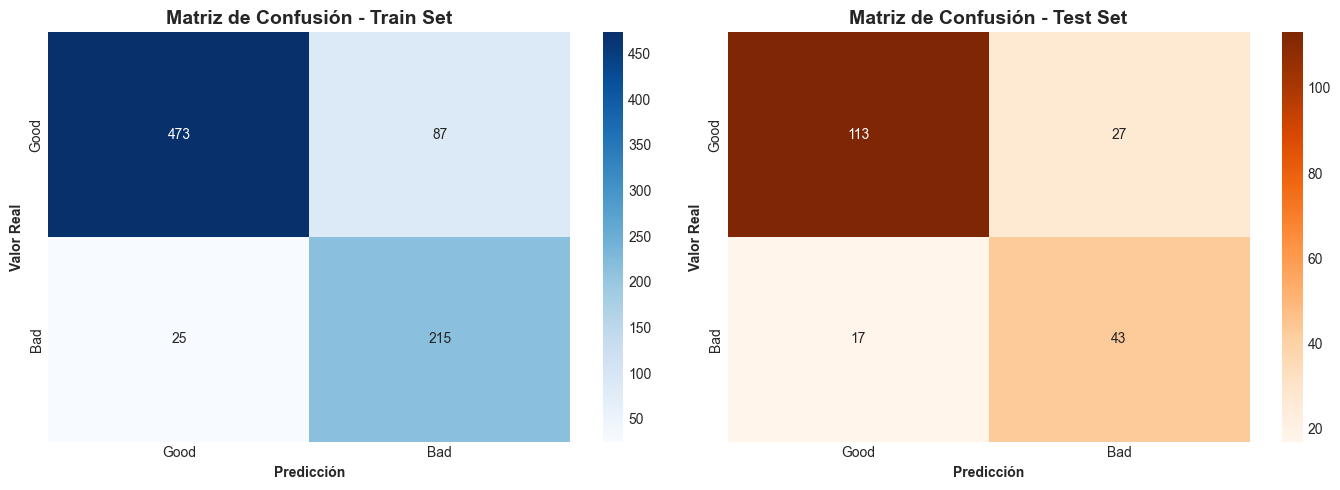


üìä Interpretaci√≥n Matriz de Confusi√≥n (Test Set):
  - True Negatives (TN): 113 - Correctamente predijo 'Good'
  - False Positives (FP): 27 - Predijo 'Bad' pero era 'Good' ‚ùå
  - False Negatives (FN): 17 - Predijo 'Good' pero era 'Bad' ‚ùå
  - True Positives (TP): 43 - Correctamente predijo 'Bad'

üí° Contexto del negocio:
  - FP (Tipo I): Rechazar buen cliente ‚Üí Oportunidad perdida
  - FN (Tipo II): Aprobar mal cliente ‚Üí P√©rdida de dinero


In [13]:
# Matriz de Confusi√≥n
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train Set
cm_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
axes[0].set_title('Matriz de Confusi√≥n - Train Set', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Valor Real', fontweight='bold')
axes[0].set_xlabel('Predicci√≥n', fontweight='bold')

# Test Set
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
axes[1].set_title('Matriz de Confusi√≥n - Test Set', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Valor Real', fontweight='bold')
axes[1].set_xlabel('Predicci√≥n', fontweight='bold')

plt.tight_layout()
plt.show()

# Interpretaci√≥n de la matriz
tn, fp, fn, tp = cm_test.ravel()
print("\nüìä Interpretaci√≥n Matriz de Confusi√≥n (Test Set):")
print(f"  - True Negatives (TN): {tn} - Correctamente predijo 'Good'")
print(f"  - False Positives (FP): {fp} - Predijo 'Bad' pero era 'Good' ‚ùå")
print(f"  - False Negatives (FN): {fn} - Predijo 'Good' pero era 'Bad' ‚ùå")
print(f"  - True Positives (TP): {tp} - Correctamente predijo 'Bad'")

print(f"\nüí° Contexto del negocio:")
print(f"  - FP (Tipo I): Rechazar buen cliente ‚Üí Oportunidad perdida")
print(f"  - FN (Tipo II): Aprobar mal cliente ‚Üí P√©rdida de dinero")


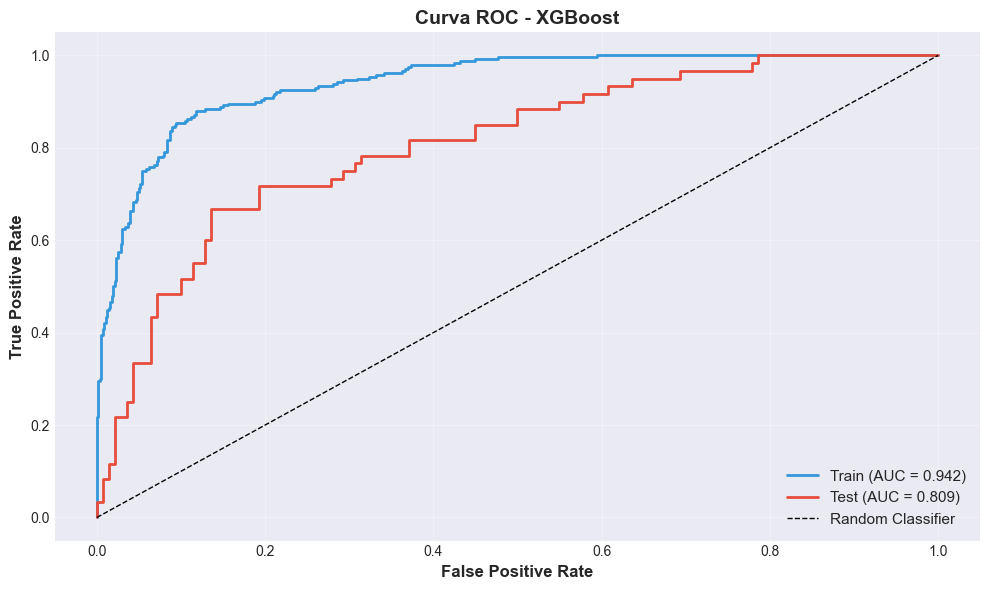

üí° Interpretaci√≥n ROC-AUC:
  - AUC = 1.0: Clasificador perfecto
  - AUC = 0.5: Random classifier (l√≠nea diagonal)
  - Nuestro modelo: 0.809


In [14]:
# Curva ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {roc_auc_score(y_train, y_pred_proba_train):.3f})', 
         linewidth=2, color='#3498db')
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {roc_auc_score(y_test, y_pred_proba_test):.3f})', 
         linewidth=2, color='#e74c3c')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Curva ROC - XGBoost', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("üí° Interpretaci√≥n ROC-AUC:")
print("  - AUC = 1.0: Clasificador perfecto")
print("  - AUC = 0.5: Random classifier (l√≠nea diagonal)")
print(f"  - Nuestro modelo: {roc_auc_score(y_test, y_pred_proba_test):.3f}")

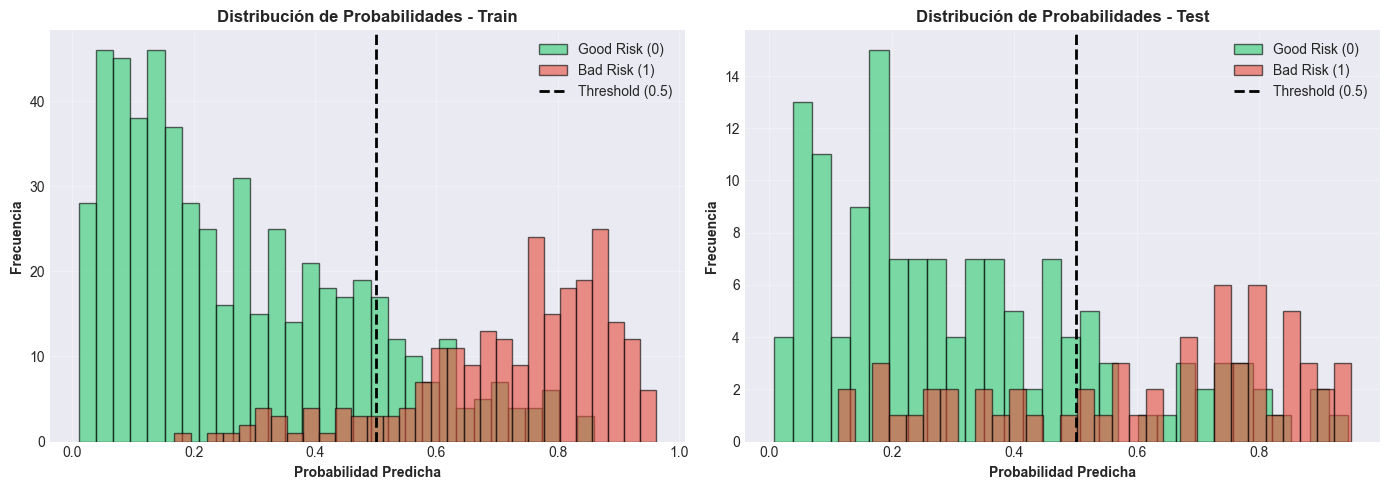


üí° Interpretaci√≥n:
  - Separaci√≥n clara entre clases ‚Üí Modelo discrimina bien
  - Solapamiento ‚Üí Clases dif√≠ciles de separar


In [15]:
# Distribuci√≥n de probabilidades predichas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train
axes[0].hist(y_pred_proba_train[y_train == 0], bins=30, alpha=0.6, 
            label='Good Risk (0)', color='#2ecc71', edgecolor='black')
axes[0].hist(y_pred_proba_train[y_train == 1], bins=30, alpha=0.6, 
            label='Bad Risk (1)', color='#e74c3c', edgecolor='black')
axes[0].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[0].set_xlabel('Probabilidad Predicha', fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontweight='bold')
axes[0].set_title('Distribuci√≥n de Probabilidades - Train', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test
axes[1].hist(y_pred_proba_test[y_test == 0], bins=30, alpha=0.6, 
            label='Good Risk (0)', color='#2ecc71', edgecolor='black')
axes[1].hist(y_pred_proba_test[y_test == 1], bins=30, alpha=0.6, 
            label='Bad Risk (1)', color='#e74c3c', edgecolor='black')
axes[1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1].set_xlabel('Probabilidad Predicha', fontweight='bold')
axes[1].set_ylabel('Frecuencia', fontweight='bold')
axes[1].set_title('Distribuci√≥n de Probabilidades - Test', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nüí° Interpretaci√≥n:")
print("  - Separaci√≥n clara entre clases ‚Üí Modelo discrimina bien")
print("  - Solapamiento ‚Üí Clases dif√≠ciles de separar")

# ## 8. Feature Importance

In [16]:
# Obtener importancia de features
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("="*60)
print("üîç FEATURE IMPORTANCE - TOP 10")
print("="*60)
print(feature_importance.head(10).to_string(index=False))

üîç FEATURE IMPORTANCE - TOP 10
            feature  importance
    checking_status    0.194410
 property_magnitude    0.067393
     savings_status    0.066304
other_payment_plans    0.062187
     credit_history    0.061148
           duration    0.052625
         employment    0.049692
      own_telephone    0.048168
    residence_since    0.045642
   existing_credits    0.042413


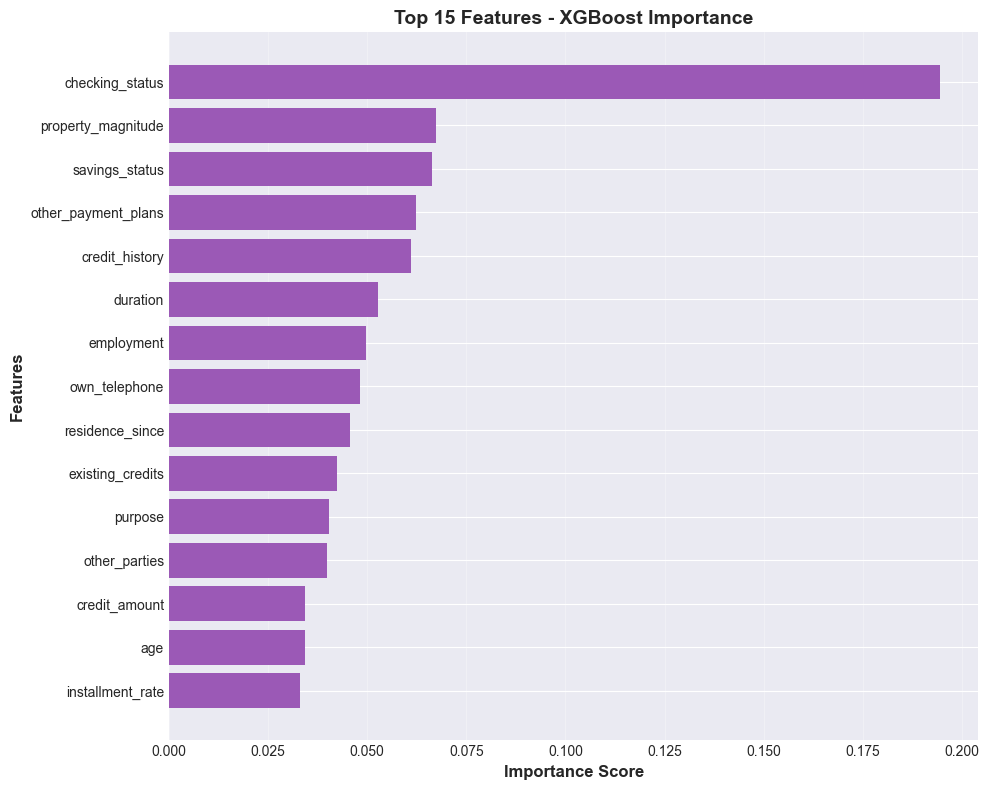


üí° Nota: Esta es la importancia B√ÅSICA de XGBoost
   En el pr√≥ximo notebook usaremos SHAP para interpretabilidad avanzada


In [17]:
# Visualizaci√≥n de Feature Importance
plt.figure(figsize=(10, 8))
top_n = 15
top_features = feature_importance.head(top_n)

plt.barh(range(top_n), top_features['importance'].values, color='#9b59b6')
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Features - XGBoost Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nüí° Nota: Esta es la importancia B√ÅSICA de XGBoost")
print("   En el pr√≥ximo notebook usaremos SHAP para interpretabilidad avanzada")


# ## 9. Guardar Modelo y Artefactos

In [18]:
# Crear carpeta para modelos si no existe
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

print("="*60)
print("üíæ GUARDANDO MODELO Y ARTEFACTOS")
print("="*60)

# Guardar modelo
model_path = models_dir / 'xgboost_model.pkl'
joblib.dump(model, model_path)
print(f"‚úÖ Modelo guardado: {model_path}")

# Guardar encoders
encoders_path = models_dir / 'label_encoders.pkl'
joblib.dump(label_encoders, encoders_path)
print(f"‚úÖ Encoders guardados: {encoders_path}")

# Guardar nombres de features (para referencia)
feature_names_path = models_dir / 'feature_names.pkl'
joblib.dump(X_train.columns.tolist(), feature_names_path)
print(f"‚úÖ Feature names guardados: {feature_names_path}")

# Guardar m√©tricas
metrics_path = models_dir / 'model_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"‚úÖ M√©tricas guardadas: {metrics_path}")


üíæ GUARDANDO MODELO Y ARTEFACTOS
‚úÖ Modelo guardado: ..\models\xgboost_model.pkl
‚úÖ Encoders guardados: ..\models\label_encoders.pkl
‚úÖ Feature names guardados: ..\models\feature_names.pkl
‚úÖ M√©tricas guardadas: ..\models\model_metrics.csv


In [19]:
# Verificar que se puede cargar correctamente
print("\nüîç Verificando carga del modelo...")

loaded_model = joblib.load(model_path)
loaded_encoders = joblib.load(encoders_path)

# Hacer una predicci√≥n de prueba
test_prediction = loaded_model.predict(X_test[:5])
print(f"‚úÖ Modelo cargado y funcional")
print(f"   Predicciones de prueba: {test_prediction}")



üîç Verificando carga del modelo...
‚úÖ Modelo cargado y funcional
   Predicciones de prueba: [0 0 1 1 0]


# ## 10. Resumen y Conclusiones

In [20]:
print("="*60)
print("üìù RESUMEN EJECUTIVO - MODELADO")
print("="*60)

print(f"""
‚úÖ MODELO ENTRENADO EXITOSAMENTE
   - Algoritmo: XGBoost Classifier
   - Features: {X_train.shape[1]}
   - Training samples: {X_train.shape[0]}
   - Test samples: {X_test.shape[0]}
   
üìä PERFORMANCE EN TEST SET
   - Accuracy: {test_acc:.3f} {'‚úÖ' if test_acc > 0.75 else '‚ùå'}
   - Precision: {metrics_df.loc[1, 'Precision']:.3f}
   - Recall: {metrics_df.loc[1, 'Recall']:.3f}
   - F1-Score: {metrics_df.loc[1, 'F1-Score']:.3f}
   - ROC-AUC: {metrics_df.loc[1, 'ROC-AUC']:.3f}
   
üîù TOP 3 FEATURES M√ÅS IMPORTANTES
   1. {feature_importance.iloc[0]['feature']}: {feature_importance.iloc[0]['importance']:.4f}
   2. {feature_importance.iloc[1]['feature']}: {feature_importance.iloc[1]['importance']:.4f}
   3. {feature_importance.iloc[2]['feature']}: {feature_importance.iloc[2]['importance']:.4f}
   
‚öñÔ∏è MANEJO DE DESBALANCEO
   - scale_pos_weight: {scale_pos_weight:.2f}
   - Estrategia efectiva: {'‚úÖ S√≠' if abs(metrics_df.loc[1, 'Precision'] - metrics_df.loc[1, 'Recall']) < 0.1 else '‚ö†Ô∏è Revisar'}
   
üíæ ARTEFACTOS GUARDADOS
   - Modelo: xgboost_model.pkl
   - Encoders: label_encoders.pkl
   - Features: feature_names.pkl
   - M√©tricas: model_metrics.csv
   
üéØ PR√ìXIMOS PASOS
   1. Implementar SHAP para interpretabilidad avanzada
   2. Analizar explicaciones individuales (waterfall plots)
   3. Identificar patrones globales (summary plots)
   4. Crear dashboard interactivo
""")

print("‚úÖ Modelado completado exitosamente")
print("üìÅ Listo para siguiente fase: Interpretabilidad con SHAP")

üìù RESUMEN EJECUTIVO - MODELADO

‚úÖ MODELO ENTRENADO EXITOSAMENTE
   - Algoritmo: XGBoost Classifier
   - Features: 20
   - Training samples: 800
   - Test samples: 200
   
üìä PERFORMANCE EN TEST SET
   - Accuracy: 0.780 ‚úÖ
   - Precision: 0.614
   - Recall: 0.717
   - F1-Score: 0.662
   - ROC-AUC: 0.809
   
üîù TOP 3 FEATURES M√ÅS IMPORTANTES
   1. checking_status: 0.1944
   2. property_magnitude: 0.0674
   3. savings_status: 0.0663
   
‚öñÔ∏è MANEJO DE DESBALANCEO
   - scale_pos_weight: 2.33
   - Estrategia efectiva: ‚ö†Ô∏è Revisar
   
üíæ ARTEFACTOS GUARDADOS
   - Modelo: xgboost_model.pkl
   - Encoders: label_encoders.pkl
   - Features: feature_names.pkl
   - M√©tricas: model_metrics.csv
   
üéØ PR√ìXIMOS PASOS
   1. Implementar SHAP para interpretabilidad avanzada
   2. Analizar explicaciones individuales (waterfall plots)
   3. Identificar patrones globales (summary plots)
   4. Crear dashboard interactivo

‚úÖ Modelado completado exitosamente
üìÅ Listo para siguiente f